In [1]:
import torch
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity
from train_mutagenicity import evaluate
from mutagenicity_utils import mol_to_query_answers, create_posterior_prob_heatmap
from dataset import get_frag_query_map
import ops

Load pre-trained model.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

model_path = './example_model.ckpt'
model = torch.load(model_path, weights_only=True, map_location=device)

classifier = ClassifierMutagenicity(queryset_size=403).to(device)
querier = QuerierMutagenicity(queryset_size=403, tau=1.0).to(device)  # Do I pass tau=1 for inference?

DEVICE: cuda


Since the model was trained with nn.DataParallel, and we called model.state_dict() in torch.save() instead of model.module.state_dict(), we still have that "module." wrapper in from of the keys of the state_dict. Next time, save the state_dict correctly, but for now, we must remove the wrapper from the key names.

In [3]:
from collections import OrderedDict

# Classifier
state_dict = model['classifier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

classifier.load_state_dict(new_state_dict)

# Querier
state_dict = model['querier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

querier.load_state_dict(new_state_dict)

<All keys matched successfully>

Define your RdKit molecule. (Currently working with smiles is messing things up for data_id=3898 in mutag dataset)

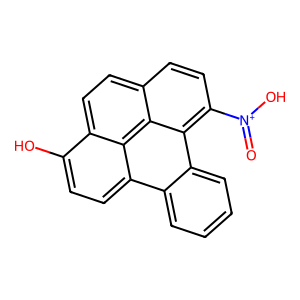

In [4]:
smiles = "[H]Oc1c([H])c([H])c2c3c([H])c([H])c([H])c([H])c3c3c([N+](=O)O)c([H])c([H])c4c([H])c([H])c1c2c43"
mol = Chem.MolFromSmiles(smiles)
img = Draw.MolToImage(mol)
img

Answer queries for the molecule.

In [ ]:
queryset = pd.read_csv('./data/rdkit_queryset.csv')
frag_query_map = get_frag_query_map(queryset)

# TODO: remove "fr_" from front of fragment names
qry_ans = mol_to_query_answers(mol, frag_query_map, device)

torch.Size([1, 403])

Evaluate model on molecule.

In [6]:
params = {
    'test_features': qry_ans,
    'querier': querier,
    'classifier': classifier,
    'n_queries': 403,
    'max_queries_test': 20,
}
logits, queries = evaluate(**params)

Set threshold for Variable Query Lengths IP.

In [7]:
THRESHOLD = 0.85
queries_needed = ops.compute_queries_needed(logits, THRESHOLD)
probs = F.softmax(logits, dim=2)

# TODO: Add this to visualization function
probs_ip = probs[0, 0:queries_needed, :]
queries_ip = queries[0, 0:queries_needed, :]

Visualize.

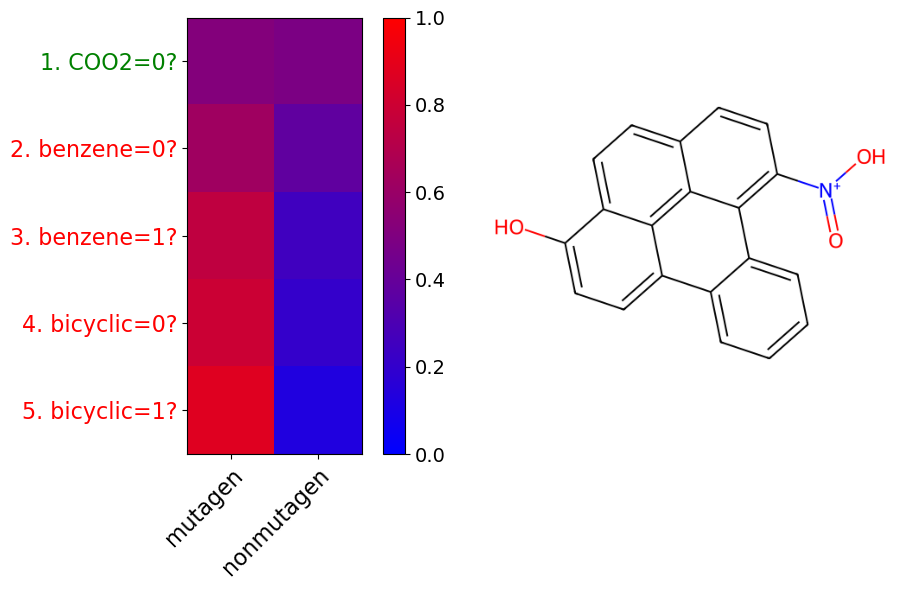

In [8]:
params = {
    'mol': mol,
    'probs': probs_ip,
    'queries': queries_ip,
    'answers': qry_ans[0],
    'threshold': 0.85,
}
fig, ax = create_posterior_prob_heatmap(**params)

In [10]:
# from dataset import load_mutagenicity_query_answer_dataset
# qry_ans_set = load_mutagenicity_query_answer_dataset('./data/Mutagenicity', './data/rdkit_queryset.csv', device)